In [22]:
import jax, jax.numpy as jnp, jax.random as jr
jax.config.update("jax_enable_x64", True)
import numpy as np, sys
import matplotlib.pyplot as plt
sys.path.insert(0, '../gimbal')
import gimbal
from tensorflow_probability import distributions as tfd

In [85]:
class KeypointSort:
    """Implements the keypoint sorting model described in [paper].
    Given keypoint observations for multiple animals, the goal
    is to infer the animal-identity for each keypoint.
    
    Inference is based on part-affinity-field scores for the keypoints
    and on a kinematics model for each animal. The kinematics model
    is modular: any model can be used as long as it can produce
    a log-likelihood score for each keypoint observation. 
    
    Parameters
    ----------
    kinematics_models : list of objects (one per animal)
        Objects to use for kinematics modeling. Must be instances of a class 
        with methods ``initialize`` ``step``, and ``log_likelihood``. All methods 
        must take observations for one animal as an argument, and ``log_likelihood`` 
        should return a log-likelihood score for each keypoint observation.
    
    observations: ndarray, shape (N,T,K,C,dim_obs)
        Location of instance i of keypoint k for time t and camera c

    affinity : ndarray, shape (N,N,T,K,C)
        Log probability that two keypoints observations belong to same animal.
        affinity[i,j,t,k,c] = log P(instance i of keypoint k is from the same
        animal as instance j of keypoint parent(k) for time t and camera c)

    identity : ndarray, shape (N,N,T,K,C)
        Log probability that each keypoint observation belongs to a specific
        animal. identity[i,j,t,k,c] = log P(instance i of keypoint k belongs
        to animal j for time t and camera c)

    initial_identity : ndarray, shape (N,N,T,K,C)
        Same as ``identity`` but used for initialization. Will be set equal
        to ``identity`` if left as None.

    assignments: ndarray, shape (N,T,K,C)
        The current animal assignment for each keypoint observation.
        assignment[i,t,k,c] = assignment of instance i of keypoint k
        for time t and camera c.  
        
    parents : ndarray, shape (K,)
        The parent of each joint. parent[i] = [parent of node i]. The root 
        node should be its own parent.
        
    top_order : ndarray, shape (K,)
        Topological ordering of joints (parents followed by children).
   
    permutations : ndarray, shape (N!,N)
        All permutations of size N
        
    """
    def __init__(self, parents,
                 kinematics_models, 
                 observations, mask,
                 affinity, identity, 
                 initial_identity=None):

        N,T,K,C, = observations.shape[:-1]
        self.parents = parents
        self.mask = mask
        self.observations = observations
        self.affinity = affinity
        self.identity = identity
        self.kinematics_models = kinematics_models
        self.initial_identity = identity if initial_identity is None else initial_identity
        
        # initialize params
        self.key = jax.random.PRNGKey(0)
        self.top_order = self.topological_sort(parents)
        self.permutations = self.all_permutations(N)
        self.clique_affinity = (affinity[self.permutations,:][:,self.permutations] 
                              * jnp.eye(N).reshape(1,N,1,N,1,1,1)).sum((1,3))
        
        self.clique_affinity_row_norm = self.normalize(self.clique_affinity, axis=1)
        self.clique_affinity_col_norm = self.normalize(self.clique_affinity, axis=0)
        
        
    def all_permutations(self,N):
        """Return all permutations of size n (one permutation per row)
        """
        import itertools
        return jnp.array(list(itertools.permutations(range(N))))

    def topological_sort(self, parents):
        """ Sort tree nodes such that parents precede children
        """
        parents = np.array(parents)
        to_go = np.ones(len(parents))>0
        topological_order = []
        while True:
            leaves = np.all([to_go,~np.in1d(np.arange(len(parents)),parents[to_go])],axis=0).nonzero()[0]
            if len(leaves)==0: break
            topological_order.append(leaves)
            to_go[leaves] = 0
        topological_order.append(to_go.nonzero()[0])
        return jnp.array(np.hstack(topological_order))[::-1]

    def initialize(self, eta=50):
        """Initialize assignments using maximum likelihood inference over 
        affinities, initial identity probabilities and keypoint proximity,
        then use these assignments to initialize the kinematics models.
        """
        self.assignments = self.initial_assignments(eta=eta)
        split_obs = self.split(self.observations,self.assignments)
        for obs,model in zip(split_obs, self.kinematics_models): model.initialize(obs)
        
    def step(self):
        """Perform one Gibbs step. Each step consists of resampling params in 
        each kinematics model (using the current assignments), and then resampling
        assignments using log probabilities from the kinematics models. 
        """
        for obs,model in zip(split_obs,self.kinematics_models): model.step(obs,self.mask)
        assign_lls = [jax.vmap(model.log_likeihood)(self.observations)*self.mask for model in self.kinematics_models]
        self.assignments = self.forward_backward_assignments(self.affinity, jnp.stack(assign_lls)+self.identity)
    
    def split(self, X, assignments):
        """Use assignments to sort an array X of shape (N,T,K,C,...) such 
        that all keypoints for animal i are in slice [i,:,:,:,...]
        """
        assignments = assignments.reshape(list(assignments.shape)+[1]*(len(X.shape)-4))
        return jnp.take_along_axis(X,assignments,axis=0)
     
    def initial_assignments(self, eta=50):
        """To initialize assignments, first get maximum likelihood assignments
        for each frame separately using just affinities and identity probabilities,
        then use the continuity of keypoint locations to optionally permute
        the labels in each frame (eta = gaussian kernel variance for continuity).
        """
        N, T, K, C, permutations = *self.observations.shape[:-1], self.permutations
        
        # the following assignments are based on optimizing each frame separately
        assignments_init = self.viterbi_assignments(self.initial_identity)
        
        # get permutation_lls[p,t,c] = log P (initial_identity | permutation p (assignments_init[time t and camera c]))
        group_lls = self.split(jnp.moveaxis(self.initial_identity,1,-1), assignments_init).sum(2)
        permutations_lls = (group_lls[self.permutations] * jnp.eye(N).reshape(1,N,1,1,N)).sum((1,4))
        
        # tmats[c,t,:,:] = permutation->permutation transitions probs, based on 
        # random walk model with variance eta for keypoint motion across frames
        obs_split = self.split(self.observations, assignments_init)
        permutation_transition_ll = ((obs_split[permutations] - obs_split[None])**2).sum((1,3,5)) / eta
        perm2perm = jnp.argmax((permutations[:,permutations][:,:,None,:]==permutations[None,None,:,:]).sum(-1),-1) 
        transition_lls = permutation_transition_ll[perm2perm,:,:]
        tmats = jnp.exp(transition_lls - transition_lls.max(1, keepdims=True))+1e-6
        log_tmats = jnp.log(jnp.transpose(tmats / tmats.sum(1, keepdims=True), axes=(3,2,0,1)))
        
        # apply simple hmm viterbi algo
        L = log_tmats * permutations_lls.T[:,:,None,:]
        P0 = jnp.ones((C,L.shape[2]))/L.shape[2]
        seqs = jax.vmap(self.viterbi_simple)(L,P0)

        # apply permutations to ``assignments_init``
        assignments_init = jnp.take_along_axis(assignments_init, self.permutations[seqs].T.reshape(N,T,1,C), axis=0)
        return assignments_init
        
    def viterbi_simple(self, L, P0):
        """Vanilla Viterbi algorithm where L[t,i,j] = log P( seq[t+1]=j | seq[t]=i )
        """
        def forward(trellis, L):
            P = trellis[:,None] + L
            trellis = P.max(0)
            pointer = jnp.argmax(P,axis=0)
            return trellis, pointer
        
        def back(i,pointer):
            return (pointer[i],pointer[i])
        trellis,pointers = jax.lax.scan(forward, P0, L)
        end_state = jnp.argmax(trellis,axis=0)
        return jax.lax.scan(back, end_state, pointers)[1]
    
    def viterbi_assignments(self, assign_lls):
        """Compute max likelihood assignments for each keypoint observation
        given affinity scores and independent keypoint/assignment log-likelihoods.
        """
        # get subtree potentials by message passing up the tree
        N, T, K, C, permutations = *self.observations.shape[:-1], self.permutations
        clique_marg = self.normalize((assign_lls[permutations] * jnp.eye(N).reshape(1,N,N,1,1,1)).sum((1,2)))
        subtree_marg = jax.lax.scan(self.tree_pass_backward, clique_marg, self.top_order[::-1])[0]
            
        # get ml assignments going down the tree
        pass_forward = jax.partial(self.tree_max_likelihood_forward, subtree_marg)
        samples = jax.lax.scan(pass_forward, jnp.zeros((T,K,C), dtype=int), self.top_order)[0]
        return jnp.transpose(permutations[samples], axes=(3,0,1,2))
    
    def forward_backward_assignments(self, assign_lls):
        """Sample posterior assignments for each keypoint observation
        given affinity scores and independent keypoint/assignment log-likelihoods.
        """
        # get subtree potentials by message passing up the tree
        N, T, K, C, permutations = *self.observations.shape[:-1], self.permutations
        clique_marg = self.normalize((assign_lls[permutations] * jnp.eye(N).reshape(1,N,N,1,1,1)).sum((1,2)))
        subtree_marg = jax.lax.scan(self.tree_pass_backward, clique_marg, self.top_order[::-1])[0]     
            
        # get full posterior sample by sampling down the tree
        self.key, newkey = jax.random.split(self.key)
        pass_forward = jax.partial(self.tree_samp_forward, subtree_marg)
        samples = jax.lax.scan(pass_forward, (newkey, jnp.zeros((T,K,C),dtype=int)), self.top_order)[0]
        return jnp.transpose(permutations[samples], axes=(3,0,1,2))
                               
    def normalize(self, X, axis=0):
        return X - jax.nn.logsumexp(X, axis=axis, keepdims=True)
    
    def tree_pass_backward(self, subtree_marg, k):
        msg = jax.nn.logsumexp(self.clique_affinity_col_norm[:,:,:,k,:]+subtree_marg[:,None,:,k,:],axis=0)
        return jax.ops.index_add(subtree_marg, jax.ops.index[:,:,self.parents[k],:], msg), None

    def tree_samp_forward(self, subtree_marg, carry, k):
        key, samples = carry
        key, newkey = jax.random.split(key)
        cond_k = self.clique_affinity_row_norm[:,samples[self.parents[k]],jnp.arange(samples.shape[0]),k,:]
        marg_k = subtree_marg[:,:,k,:] + cond_k
        sample = jax.random.categorical(newkey, marg_k, axis=0)
        return (key,jax.ops.index_update(samples, k, sample)), None
                               
    def tree_max_likelihood_forward(self, subtree_marg, samples, k): 
        cond_k = self.clique_affinity_row_norm[:,samples[:,self.parents[k],:],
                                               jnp.arange(samples.shape[0])[:,None],k,
                                               jnp.arange(samples.shape[2])[None,:]]
        sample = jnp.argmax(subtree_marg[:,:,k,:] + cond_k, axis=0)
        return jax.ops.index_update(samples, jax.ops.index[:,k,:], sample), None
    

In [126]:
A = np.load('../../21_11_23_opto_attack_with_PFC_recordings_v1/data/21_11_23_MeA8A_GRIN63.rig0.bottom.A.npy')
I = np.load('../../21_11_23_opto_attack_with_PFC_recordings_v1/data/21_11_23_MeA8A_GRIN63.rig0.bottom.I.npy')
Y = np.load('../../21_11_23_opto_attack_with_PFC_recordings_v1/data/21_11_23_MeA8A_GRIN63.rig0.bottom.Y.npy')

A = np.transpose(A,axes=(2,3,0,1))[:,:,:,:,None] * 2
I = np.transpose(I,axes=(2,3,0,1))[:,:,:,:,None] * 1.2
Y = np.transpose(Y,axes=(2,0,1,3))[:,:,:,None,:].astype(float)

low_scoring_points = np.repeat(I.max(1, keepdims=True) < 0.25, I.shape[1], axis=1) 
Y[np.transpose(low_scoring_points, axes=(0,2,3,4,1))] = np.nan
A[low_scoring_points] = 0

parents = jnp.array([2, 2, 5, 5, 5, 5, 5, 5, 5])
A = jnp.array(A)
I = jnp.array(I)
Y = jnp.array(Y)

In [127]:
kps = keypointSort(parents,Y,A,I)
ii = kps.initial_assignments()
YY = kps.split(Y,ii)

In [ ]:
# - tail_tip
# - tail_base
# - genitals_dorsal-tip
# - left_foot
# - right_foot
# - centroid
# - left_hand
# - right_hand
# - nose_tip

In [174]:
self = kps
eta=10
N, T, K, C, permutations = *self.observations.shape[:-1], self.permutations

# the following assignments are based on optimizing each frame separately
assignments_init = self.viterbi_assignments(self.initial_identity)

# get permutation_lls[p,t,c] = log P (initial_identity | permutation p (assignments_init[time t and camera c]))
group_lls = self.split(jnp.moveaxis(self.initial_identity,1,-1), assignments_init).sum(2)
permutations_lls = (group_lls[self.permutations] * jnp.eye(N).reshape(1,N,1,1,N)).sum((1,4))

# tmats[c,t,:,:] = permutation->permutation transitions probs, based on 
# random walk model with variance eta for keypoint motion across frames
obs_split = self.split(self.observations, assignments_init)
permutation_transition_ll = -(jnp.nan_to_num(obs_split[permutations,1:] - obs_split[None,:,:-1])**2).sum((1,3,5)) / eta
perm2perm = jnp.argmax((permutations[:,permutations][:,:,None,:]==permutations[None,None,:,:]).sum(-1),-1) 
transition_lls = permutation_transition_ll[perm2perm,:,:]
tmats = jnp.exp(transition_lls - transition_lls.max(1, keepdims=True))+1e-6
log_tmats = jnp.log(jnp.transpose(tmats / tmats.sum(1, keepdims=True), axes=(3,2,0,1)))

# apply simple hmm viterbi algo
L = log_tmats * permutations_lls.T[:,1:,None,:]
P0 = jnp.ones((C,L.shape[2]))/L.shape[2]
seqs = jax.vmap(self.viterbi_simple)(L,P0)

# apply permutations to ``assignments_init``
seqs = jnp.pad(seqs,((0,0),(1,0)))
assignments_init = jnp.take_along_axis(assignments_init, self.permutations[seqs].T.reshape(N,T,1,C), axis=0)



In [175]:
YY = kps.split(Y,assignments_init)

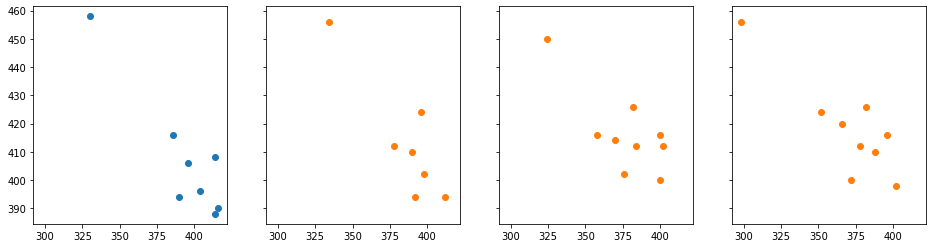

In [188]:
import matplotlib.pyplot as plt
t = np.random.randint(0,A.shape[2]-40)
fig,axs = plt.subplots(1,4, sharey=True, sharex=True)
for i in range(4):
    axs[i].scatter(YY[0,t+10*i,:,0,0],YY[0,t+10*i,:,0,1])
    axs[i].scatter(YY[1,t+10*i,:,0,0],YY[1,t+10*i,:,0,1])
fig.set_size_inches((16,4))